# Load returns to AWS SQL db

In [1]:
import psycopg2
from psycopg2 import sql
from dotenv import load_dotenv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
from loguru import logger
import sys
import time
# Load environment variables from the .secrets file
load_dotenv(".secrets")

True

In [2]:
# Configure Loguru logger
logger.remove()  # Remove default handler to set a custom configuration
logger.add(sys.stderr,format="<green>{time:YYYY-MM-DD HH:mm:ss}</green> | <level>{level}</level> | <level>{message}</level>",level="DEBUG")

1

### User-defined parameters

In [3]:
# Directory containing the files
directory_path = 'data/returns'
add_new_data = False

## Create Table if does not exist

In [4]:
# Database connection parameters from environment variables
DB_NAME = os.getenv("AWS_RDS_DBNAME")
USER = os.getenv("AWS_RDS_USERNAME")
PASSWORD = os.getenv("AWS_RDS_PASSWORD")
HOST = os.getenv("AWS_RDS_HOST")
PORT = os.getenv("AWS_RDS_PORT")

# Connect to PostgreSQL database
conn = psycopg2.connect(
    dbname=DB_NAME,
    user=USER,
    password=PASSWORD,
    host=HOST,
    port=PORT
)
cur = conn.cursor()
conn


# SQL command to create the table with specified requirements and unique constraint
create_table_query = '''
CREATE TABLE IF NOT EXISTS public.pe_returns (
    vintage_year VARCHAR NOT NULL,
    asset_class VARCHAR NOT NULL,
    geo_region VARCHAR NOT NULL,
    first_transaction_period VARCHAR,
    as_of_date TIMESTAMP NOT NULL,
    fund_count FLOAT,
    irr_pooled FLOAT,
    irr_equal_weighted FLOAT,
    irr_capital_weighted FLOAT,
    irr_average FLOAT,
    irr_top_5 FLOAT,
    irr_upper_quartile FLOAT,
    irr_median FLOAT,
    irr_lower_quartile FLOAT,
    irr_bottom_5 FLOAT,
    irr_std_dev FLOAT,
    tvpi_pooled FLOAT,
    tvpi_capital_weighted FLOAT,
    tvpi_average FLOAT,
    tvpi_top_5 FLOAT,
    tvpi_upper_quartile FLOAT,
    tvpi_median FLOAT,
    tvpi_lower_quartile FLOAT,
    tvpi_bottom_5 FLOAT,
    tvpi_std_dev FLOAT,
    dpi_pooled FLOAT,
    dpi_capital_weighted FLOAT,
    dpi_average FLOAT,
    dpi_top_5 FLOAT,
    dpi_upper_quartile FLOAT,
    dpi_median FLOAT,
    dpi_lower_quartile FLOAT,
    dpi_bottom_5 FLOAT,
    dpi_std_dev FLOAT,
    PRIMARY KEY (vintage_year, asset_class, geo_region, as_of_date),
    CONSTRAINT unique_entry_constraint UNIQUE (vintage_year, asset_class, geo_region, as_of_date)

);
'''

# Execute the create table command
if add_new_data:
    cur.execute(create_table_query)
    conn.commit()
    logger.success("Table created successfully with unique constraint.")
else:
    logger.warning(f'No table created add_new_data==False')

cur.close()
conn.close()


2024-11-07 12:29:12 | WARNING | No table created add_new_data==False


## Load CSV and write to tables

In [5]:
# Column mapping for renaming
column_mapping = {
    'Vintage Year': 'vintage_year',
    'Asset Class Group': 'asset_class',
    'First Transaction Period': 'first_transaction_period',
    'As of Date': 'as_of_date',
    'Fund Count': 'fund_count',
    'Pooled Return (LP) (%)': 'irr_pooled',
    'Equal Weighted (LP) (%)': 'irr_equal_weighted',
    'Capital Weighted (LP) (%)': 'irr_capital_weighted',
    'Average (LP) (%)': 'irr_average',
    'Top 5% (LP) (%)': 'irr_top_5',
    'Upper Quartile (LP) (%)': 'irr_upper_quartile',
    'Median (LP) (%)': 'irr_median',
    'Lower Quartile (LP) (%)': 'irr_lower_quartile',
    'Bottom 5% (LP) (%)': 'irr_bottom_5',
    'Standard Deviation (LP) (%)': 'irr_std_dev',
    'Pooled Return (LP)': 'tvpi_pooled',
    'Capital Weighted (LP)': 'tvpi_capital_weighted',
    'Average (LP)': 'tvpi_average',
    'Top 5% (LP)': 'tvpi_top_5',
    'Upper Quartile (LP)': 'tvpi_upper_quartile',
    'Median (LP)': 'tvpi_median',
    'Lower Quartile (LP)': 'tvpi_lower_quartile',
    'Bottom 5% (LP)': 'tvpi_bottom_5',
    'Standard Deviation (LP)': 'tvpi_std_dev',
    'Pooled Return (LP).1': 'dpi_pooled',
    'Capital Weighted (LP).1': 'dpi_capital_weighted',
    'Average (LP).1': 'dpi_average',
    'Top 5% (LP).1': 'dpi_top_5',
    'Upper Quartile (LP).1': 'dpi_upper_quartile',
    'Median (LP).1': 'dpi_median',
    'Lower Quartile (LP).1': 'dpi_lower_quartile',
    'Bottom 5% (LP).1': 'dpi_bottom_5',
    'Standard Deviation (LP).1': 'dpi_std_dev'
}


def clean_invalid_entries(df):
    # List of values to consider as NULL
    null_values = ["--", "---", "NaN", "nan", "NaT", "", None]

    # Replace invalid values with None
    return df.replace(null_values, None)

def process_and_upload_file(file_path, geo_region):
    try:
        # Read and clean the file as before
        data = pd.read_excel(file_path, sheet_name='Returns Report', header=4)
        data = data.assign(geo_region=geo_region)

        # Remove unwanted rows and clean invalid entries
        total_row_index = data[data['Vintage Year'] == 'Total'].index
        if not total_row_index.empty:
            data = data.loc[:total_row_index[0] - 1]
        data = data[data['Asset Class Group'] != 'Sub-Total']
        data = clean_invalid_entries(data)

        # Connect to the database and insert rows
        row_count = len(data)  # Get the number of rows to be inserted

        # Convert columns to numeric where applicable, handling errors
        columns_to_convert = data.columns[5:33]
        data[columns_to_convert] = data[columns_to_convert].apply(pd.to_numeric, errors='coerce')

        # Rename columns
        data.rename(columns=column_mapping, inplace=True)

        # Connect to the PostgreSQL database
        conn = psycopg2.connect(
            dbname=DB_NAME,
            user=USER,
            password=PASSWORD,
            host=HOST,
            port=PORT
        )
        cur = conn.cursor()

        # Upload data to PostgreSQL
        for _, row in data.iterrows():
            # Convert row to tuple, replacing any NaNs with None
            row_data = tuple(None if pd.isna(value) else value for value in [
                row['vintage_year'], row['asset_class'], row['geo_region'], row['first_transaction_period'],
                row['as_of_date'], row['fund_count'], row['irr_pooled'], row['irr_equal_weighted'],
                row['irr_capital_weighted'], row['irr_average'], row['irr_top_5'], row['irr_upper_quartile'],
                row['irr_median'], row['irr_lower_quartile'], row['irr_bottom_5'], row['irr_std_dev'],
                row['tvpi_pooled'], row['tvpi_capital_weighted'], row['tvpi_average'], row['tvpi_top_5'],
                row['tvpi_upper_quartile'], row['tvpi_median'], row['tvpi_lower_quartile'], row['tvpi_bottom_5'],
                row['tvpi_std_dev'], row['dpi_pooled'], row['dpi_capital_weighted'], row['dpi_average'],
                row['dpi_top_5'], row['dpi_upper_quartile'], row['dpi_median'], row['dpi_lower_quartile'],
                row['dpi_bottom_5'], row['dpi_std_dev']
            ])

            insert_query = '''
            INSERT INTO public.pe_returns (vintage_year, asset_class, geo_region, first_transaction_period, as_of_date, fund_count,
                irr_pooled, irr_equal_weighted, irr_capital_weighted, irr_average, irr_top_5, irr_upper_quartile,
                irr_median, irr_lower_quartile, irr_bottom_5, irr_std_dev, tvpi_pooled, tvpi_capital_weighted,
                tvpi_average, tvpi_top_5, tvpi_upper_quartile, tvpi_median, tvpi_lower_quartile, tvpi_bottom_5,
                tvpi_std_dev, dpi_pooled, dpi_capital_weighted, dpi_average, dpi_top_5, dpi_upper_quartile, dpi_median,
                dpi_lower_quartile, dpi_bottom_5, dpi_std_dev)
            VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
            ON CONFLICT ON CONSTRAINT unique_entry_constraint DO NOTHING;
            '''
            cur.execute(insert_query, row_data)

        # Commit transaction
        conn.commit()
        logger.success(f"Data from {file_path} uploaded successfully.")
        return row_count  # Return the row count for this file

    except Exception as e:
        logger.error(f"Error processing {file_path}: {e}")
    finally:
        # Ensure resources are closed
        cur.close()
        conn.close()


def load_pe_returns():
    files = [f for f in os.listdir(directory_path) if f.endswith(".xlsx")]
    file_statistics = {}  # Dictionary to store row count per file
    total_rows = 0  # Variable to store total row count

    # Thread-safe progress bar
    with ThreadPoolExecutor() as executor, tqdm(total=len(files), leave=True, dynamic_ncols=True) as progress_bar:
        futures = {}
        for filename in files:
            geo_region = filename.split('_')[-1].replace('.xlsx', '')  # Determine region based on filename
            file_path = os.path.join(directory_path, filename)
            # Each future holds the filename and the function result (row count)
            futures[executor.submit(process_and_upload_file, file_path, geo_region)] = filename
            logger.debug(f"Started processing {file_path}")

        # Process the results as each thread completes
        for future in as_completed(futures):
            filename = futures[future]
            try:
                row_count = future.result()  # Get row count from the function
                file_statistics[filename] = row_count
                total_rows += row_count
                logger.info(f"Loaded {row_count} rows from {filename}.")
            except Exception as e:
                logger.error(f"Error processing {filename}: {e}")
            progress_bar.update(1)
            progress_bar.refresh()  # Refresh to avoid overlap with log entries

    # Display final statistics
    logger.success(f"All files processed successfully.")
    time.sleep(.500)
    logger.info(f"Number of files loaded: {len(file_statistics)}")
    for filename, row_count in file_statistics.items():
        logger.info(f"File: {filename} - Rows loaded: {row_count}")
    logger.info(f"Total number of rows loaded: {total_rows}")


# Run the function directly in the notebook
if add_new_data:
    logger.info("Starting PE Returns data upload.")
    time.sleep(.500)
    load_pe_returns()
    logger.success("PE Returns data upload completed.")
else:
    logger.warning(f'No data loaded add_new_data==False')

2024-11-07 12:29:12 | WARNING | No data loaded add_new_data==False


## Double-check read PE_Returns data

In [6]:
# Connect to PostgreSQL and read the table into a DataFrame
conn = psycopg2.connect(
    dbname=DB_NAME,
    user=USER,
    password=PASSWORD,
    host=HOST,
    port=PORT
)

# Query the data
query = "SELECT * FROM public.pe_returns;"
data = pd.read_sql(query, conn)

# Close the connection
conn.close()

# Sort data as requested
data.sort_values(by=['vintage_year', 'asset_class', 'geo_region'], inplace=True)

# 1. Stats of None Values
print("Null Values Analysis:")
null_stats = data.isnull().sum()
print(null_stats)
# 2. Descriptive Statistics
print("\nDescriptive Statistics:")
desc_stats = data.describe()
desc_stats

#

C:\Users\Lorenzo\AppData\Local\Temp\ipykernel_11836\4000037139.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data = pd.read_sql(query, conn)


Null Values Analysis:
vintage_year                  0
asset_class                   0
geo_region                    0
first_transaction_period      0
as_of_date                    0
fund_count                    0
irr_pooled                  187
irr_equal_weighted          187
irr_capital_weighted        187
irr_average                 187
irr_top_5                   421
irr_upper_quartile          421
irr_median                  305
irr_lower_quartile          421
irr_bottom_5                421
irr_std_dev                 421
tvpi_pooled                 187
tvpi_capital_weighted       187
tvpi_average                187
tvpi_top_5                  421
tvpi_upper_quartile         421
tvpi_median                 305
tvpi_lower_quartile         421
tvpi_bottom_5               421
tvpi_std_dev                421
dpi_pooled                  187
dpi_capital_weighted        187
dpi_average                 187
dpi_top_5                   421
dpi_upper_quartile          421
dpi_median        

,as_of_date,fund_count,irr_pooled,irr_equal_weighted,irr_capital_weighted,irr_average,irr_top_5,irr_upper_quartile,irr_median,irr_lower_quartile,...,tvpi_std_dev,dpi_pooled,dpi_capital_weighted,dpi_average,dpi_top_5,dpi_upper_quartile,dpi_median,dpi_lower_quartile,dpi_bottom_5,dpi_std_dev
count,753,753.000000,566.000000,566.000000,566.000000,566.000000,332.000000,332.000000,448.000000,332.000000,...,332.000000,566.000000,566.000000,566.000000,332.000000,332.000000,448.000000,332.000000,332.000000,332.000000
mean,2024-03-31 00:00:00,13.414343,0.120868,0.122990,0.113724,0.108808,0.356643,0.178725,0.097782,0.043828,...,1.684747,1.273073,1.379588,1.364279,3.236139,1.531821,1.110225,0.826552,0.479031,1.544203
min,2024-03-31 00:00:00,1.000000,-0.176088,-0.254985,-0.443469,-0.316297,0.012756,-0.112538,-0.276032,-0.427130,...,0.075571,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2024-03-31 00:00:00,3.000000,0.067608,0.064597,0.062349,0.056513,0.201766,0.113622,0.060645,0.009573,...,0.422472,0.745311,0.741871,0.703032,1.441847,0.985385,0.588843,0.332364,0.061800,0.390300
50%,2024-03-31 00:00:00,6.000000,0.109500,0.109916,0.109174,0.103144,0.268688,0.163280,0.101294,0.058434,...,0.624230,1.268182,1.282232,1.280978,2.176082,1.604982,1.229444,0.898294,0.370570,0.596706
75%,2024-03-31 00:00:00,16.000000,0.160917,0.157765,0.157308,0.154108,0.384256,0.216100,0.143697,0.092876,...,1.065106,1.678138,1.686397,1.717927,2.974125,2.027135,1.601157,1.308541,0.790240,0.905308
max,2024-03-31 00:00:00,171.000000,1.066776,3.280427,1.601510,2.879310,7.496766,0.926855,0.347700,0.206819,...,221.717771,5.896937,59.265441,55.357788,219.866662,5.382987,2.853916,2.059332,1.604251,218.163861
std,NaN,19.214451,0.109162,0.166877,0.124402,0.152212,0.482343,0.118095,0.077279,0.077930,...,12.180823,0.848610,2.583589,2.419200,12.160723,0.930284,0.670151,0.551773,0.437594,11.980555


### Quantile anomalies

In [7]:
import pandas as pd

# Define function to check if row meets the defined rules for each performance metric group, ignoring NaNs
def check_anomaly(row, metric_prefix):
    # Extract values for each metric
    top_5 = row[f'{metric_prefix}_top_5']
    upper_quartile = row[f'{metric_prefix}_upper_quartile']
    median = row[f'{metric_prefix}_median']
    lower_quartile = row[f'{metric_prefix}_lower_quartile']
    bottom_5 = row[f'{metric_prefix}_bottom_5']
    
    # Only perform checks if all values are not NaN
    if pd.notna(top_5) and pd.notna(upper_quartile) and pd.notna(median) and pd.notna(lower_quartile) and pd.notna(bottom_5):
        
        # Otherwise, check the rule conditions
        return not (
            top_5 >= upper_quartile and
            upper_quartile >= median and
            median >= lower_quartile and
            lower_quartile >= bottom_5
        )
    return False  # If there are NaNs, we consider the row as non-anomalous for this metric

# List of metric prefixes to analyze
metric_prefixes = ['tvpi', 'dpi', 'irr']

# Initialize an empty list to store the index of anomalies
anomaly_indices = []

# Iterate through each row to check for anomalies
for idx, row in data.iterrows():
    # Check each metric prefix for anomalies
    for prefix in metric_prefixes:
        if check_anomaly(row, prefix):
            anomaly_indices.append(idx)
            break  # Stop checking other metrics if one anomaly is found

# Filter the rows identified as anomalies
anomalies = data.loc[anomaly_indices]

# Display results
print("Detected Anomalies Based on Performance Metrics Order Rules (Ignoring NaNs and Allowing Equal Values):")
anomalies




Detected Anomalies Based on Performance Metrics Order Rules (Ignoring NaNs and Allowing Equal Values):


,vintage_year,asset_class,geo_region,first_transaction_period,as_of_date,fund_count,irr_pooled,irr_equal_weighted,irr_capital_weighted,irr_average,...,tvpi_std_dev,dpi_pooled,dpi_capital_weighted,dpi_average,dpi_top_5,dpi_upper_quartile,dpi_median,dpi_lower_quartile,dpi_bottom_5,dpi_std_dev


### Plots

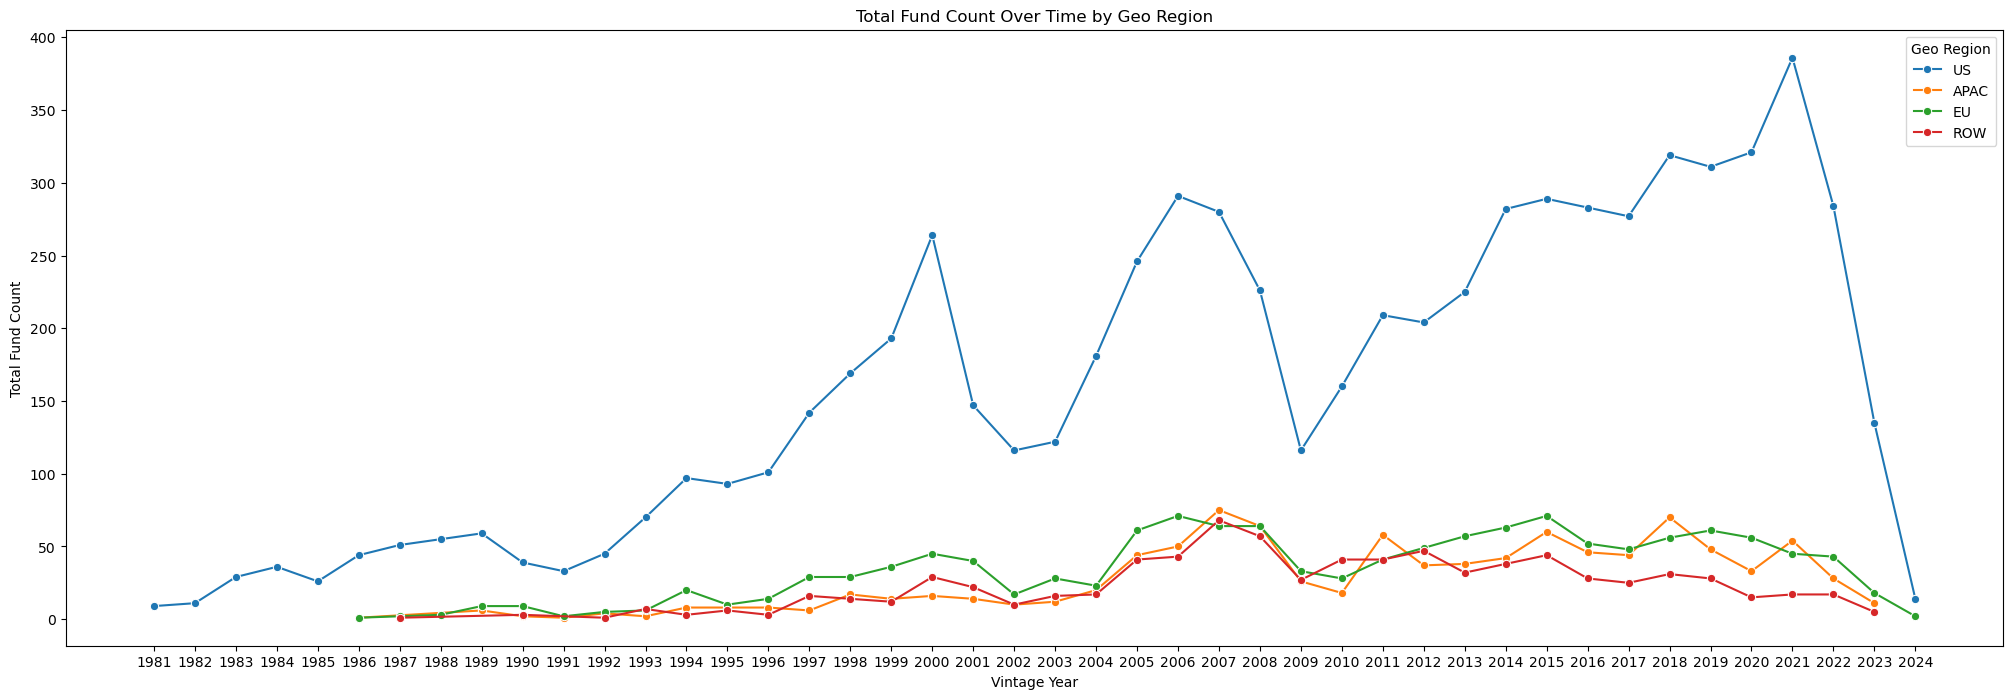

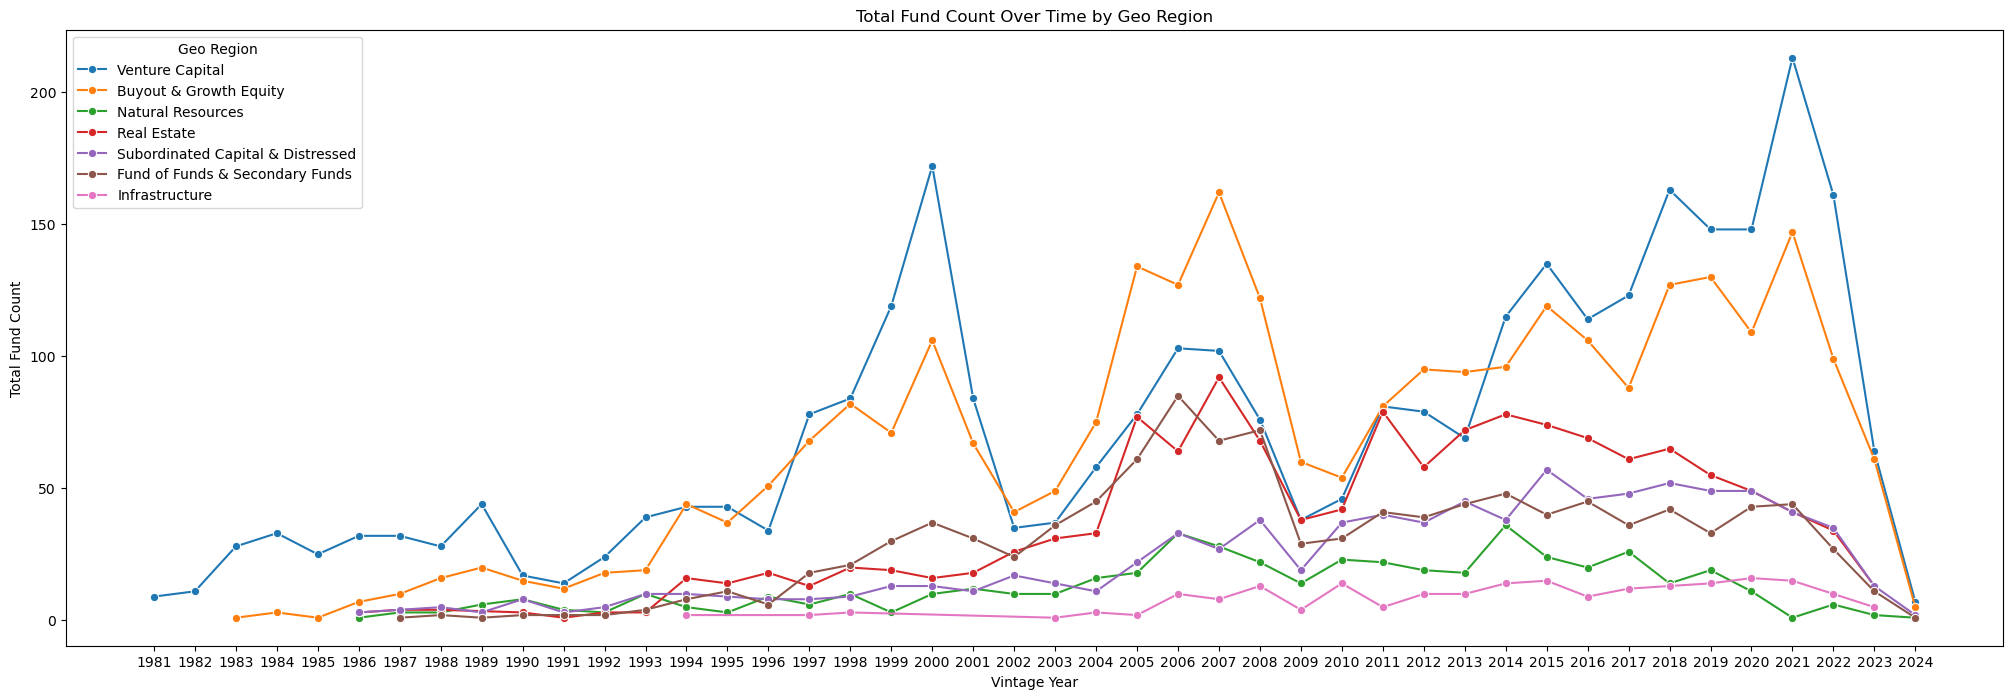

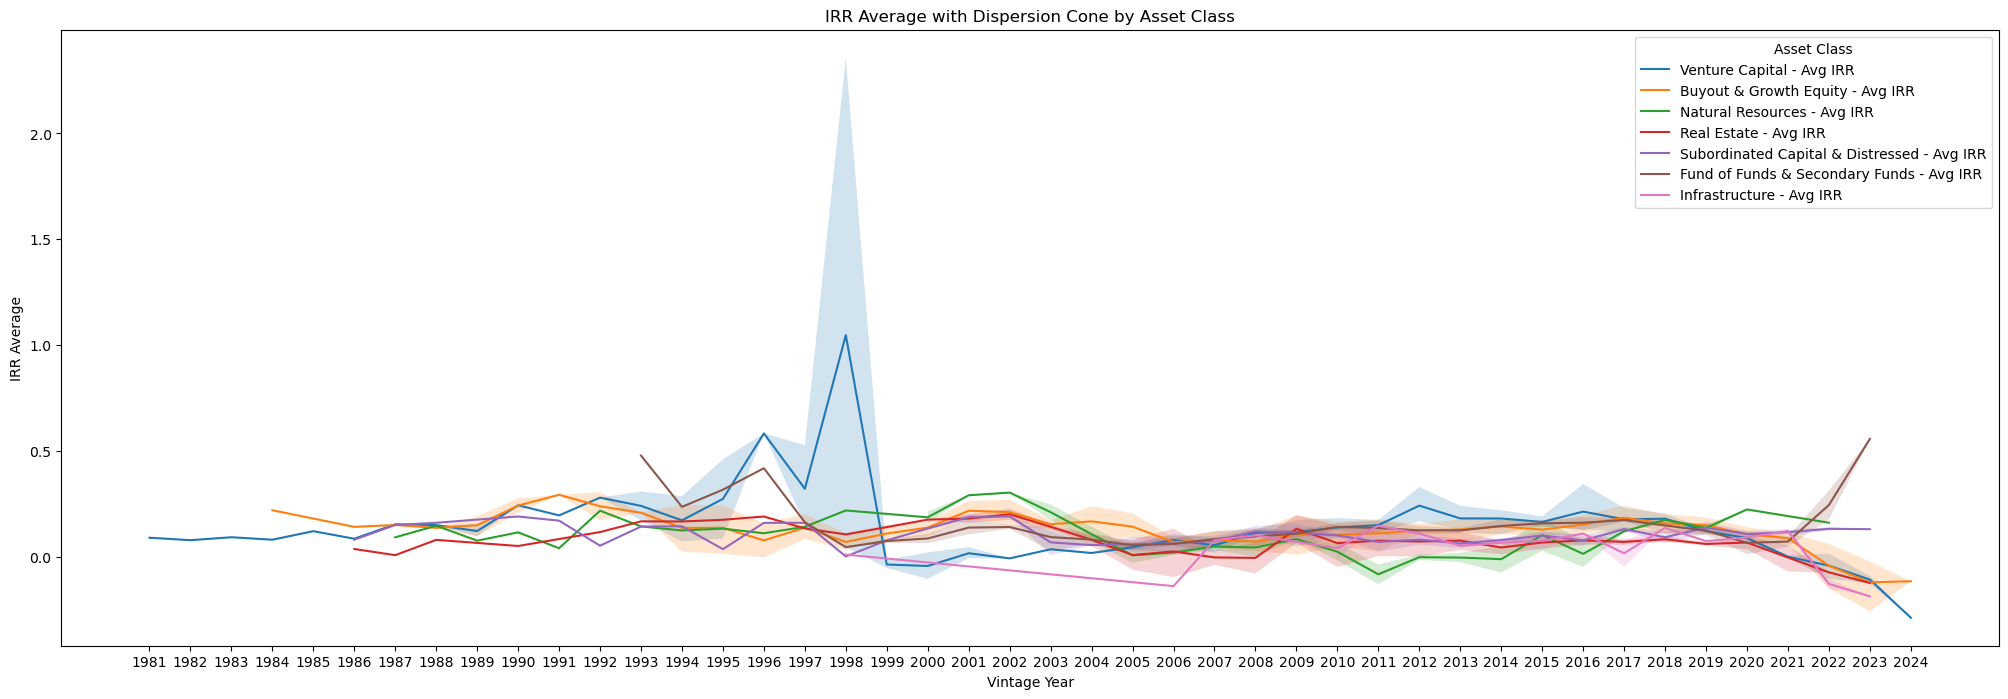

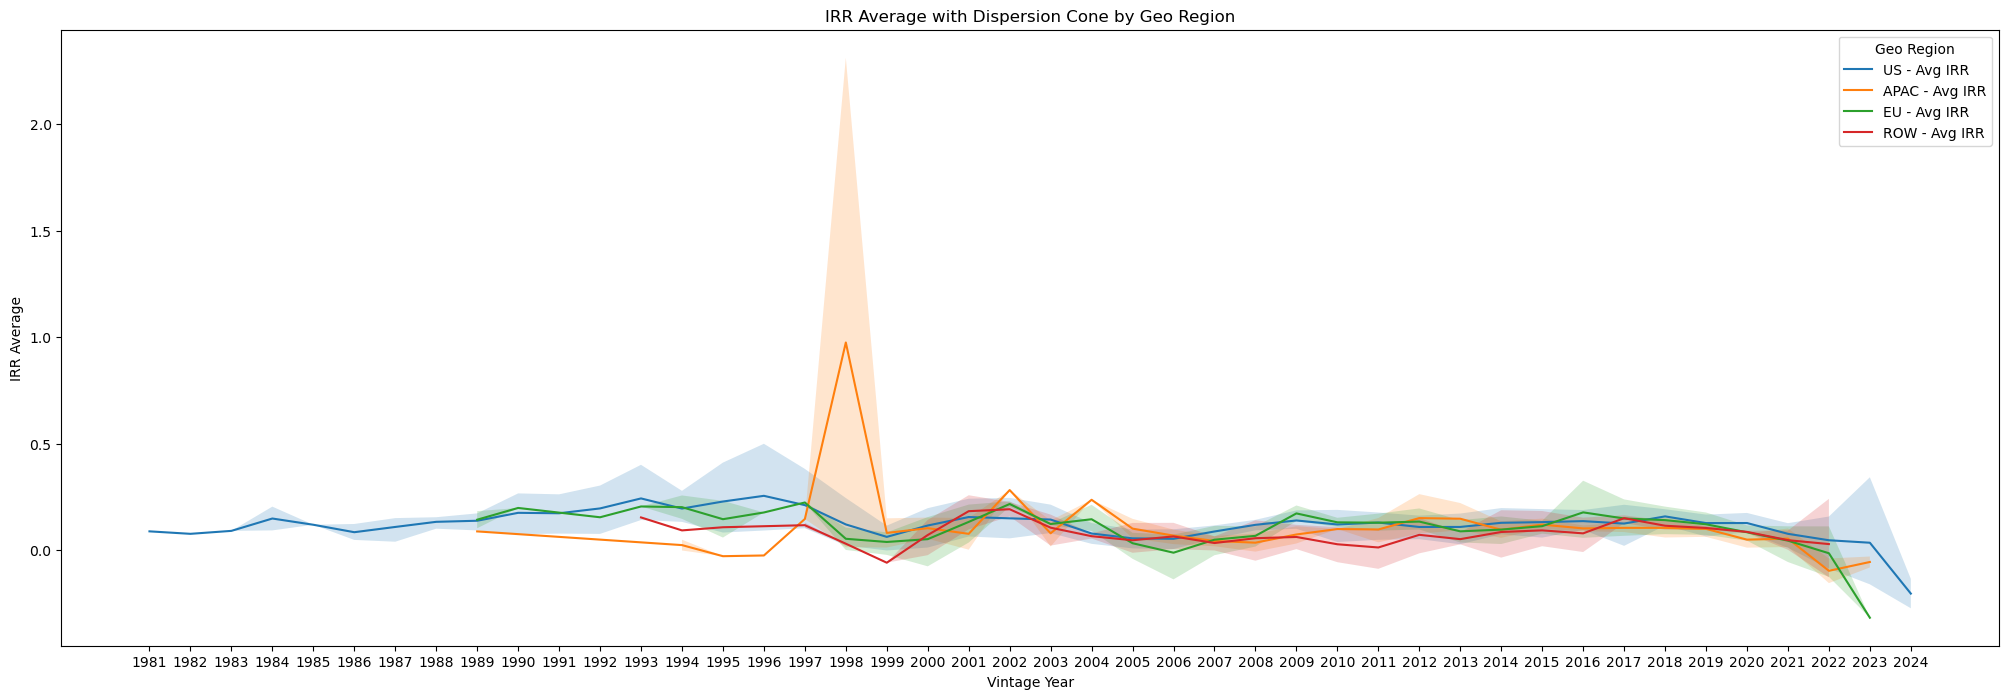

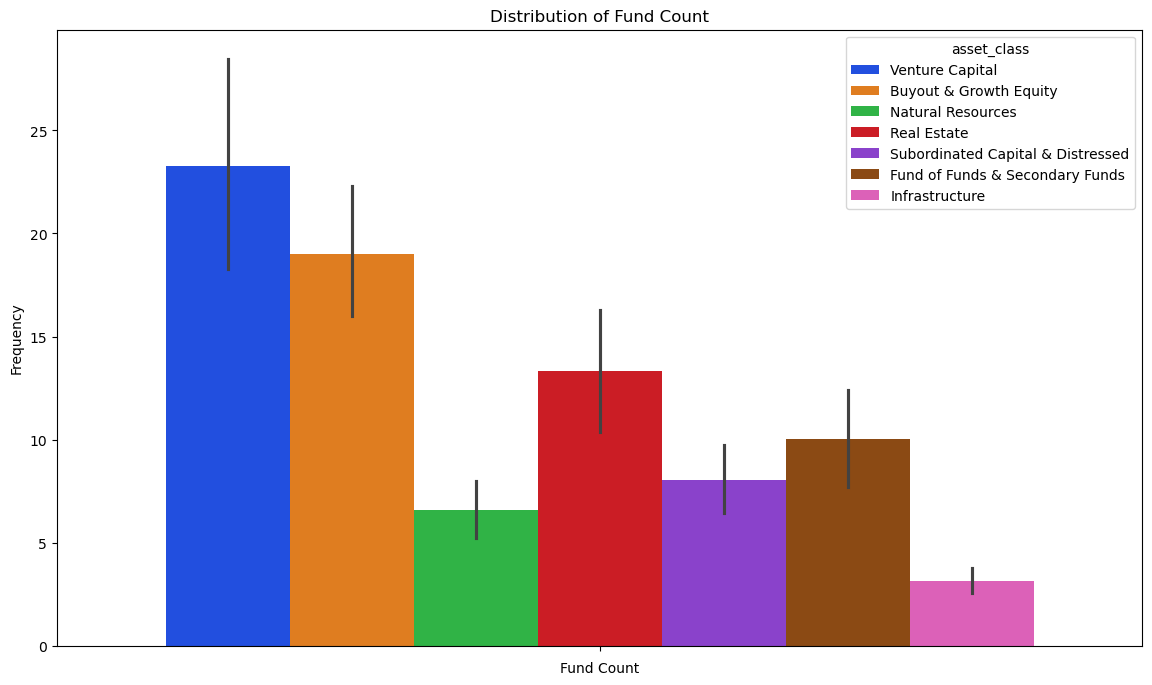

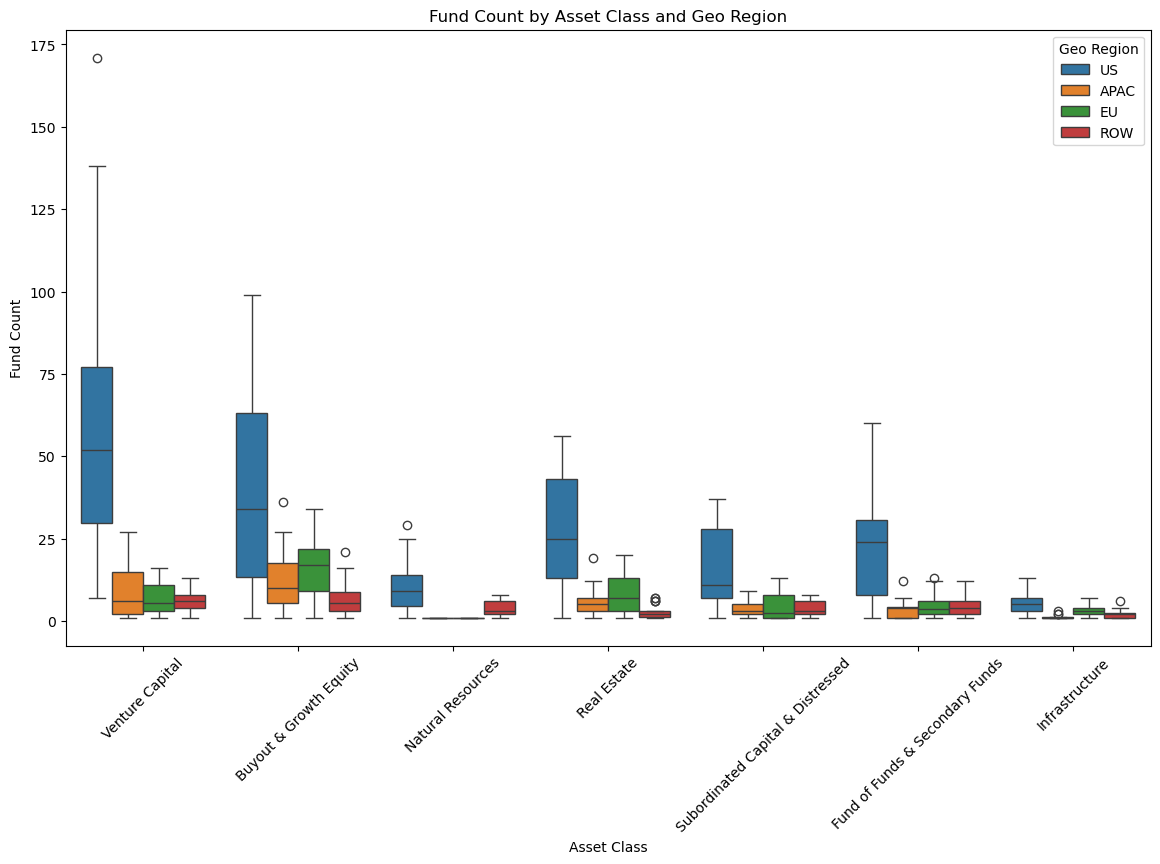

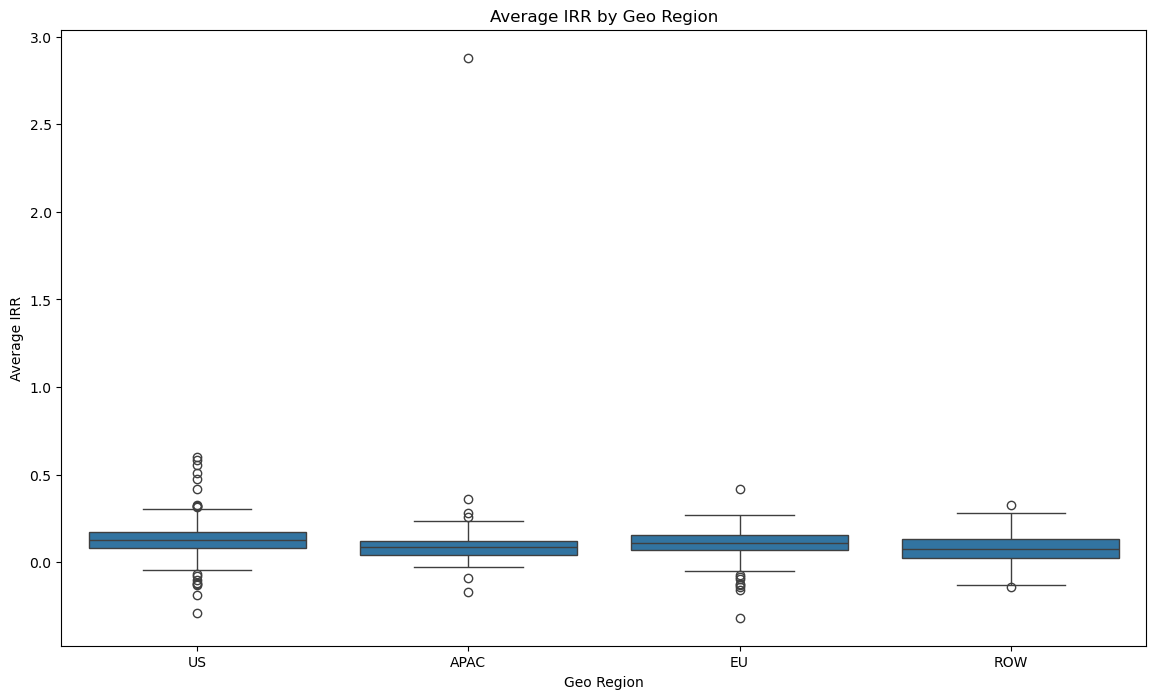

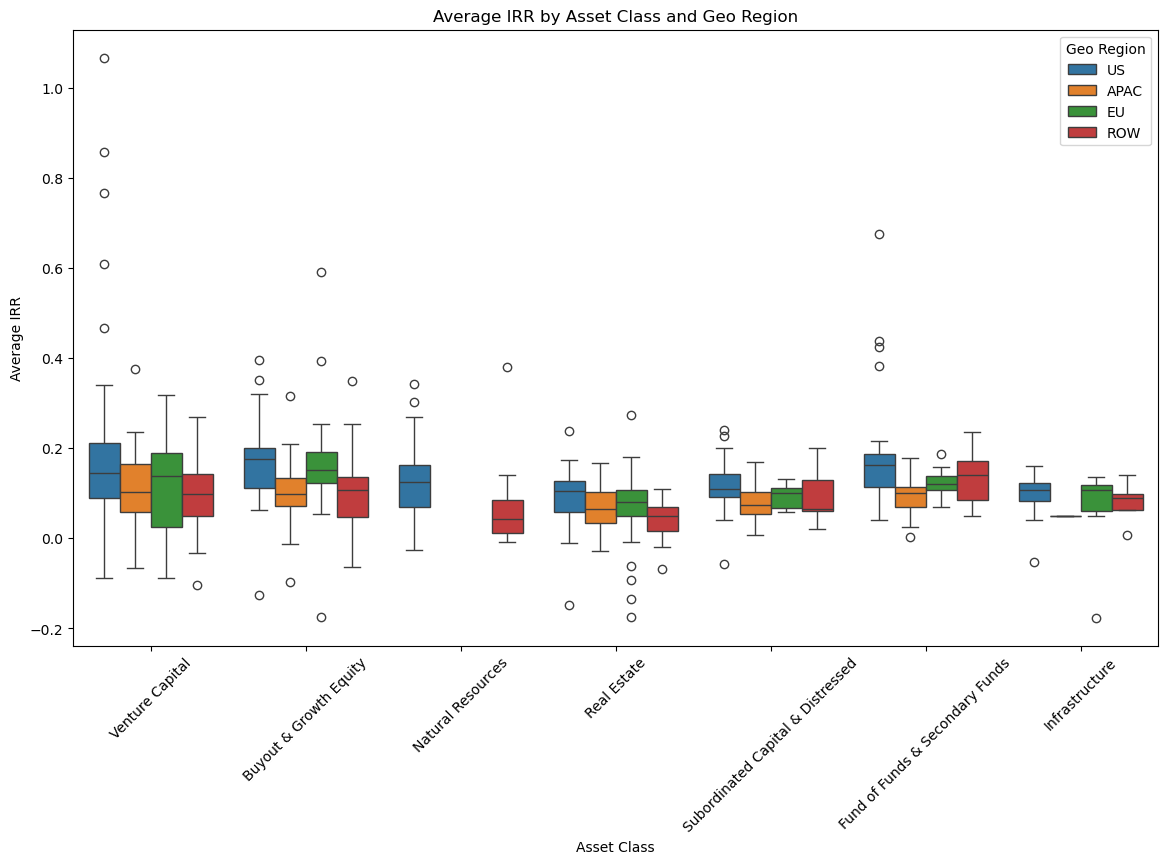

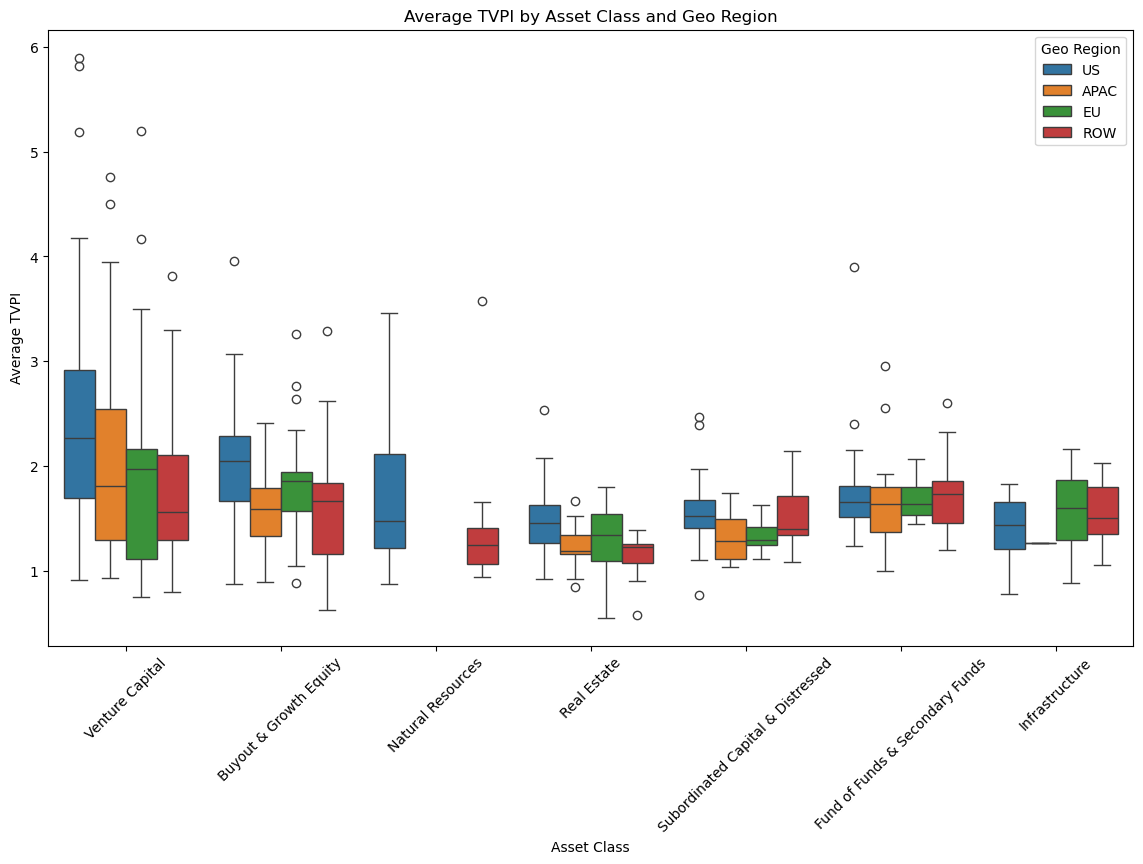

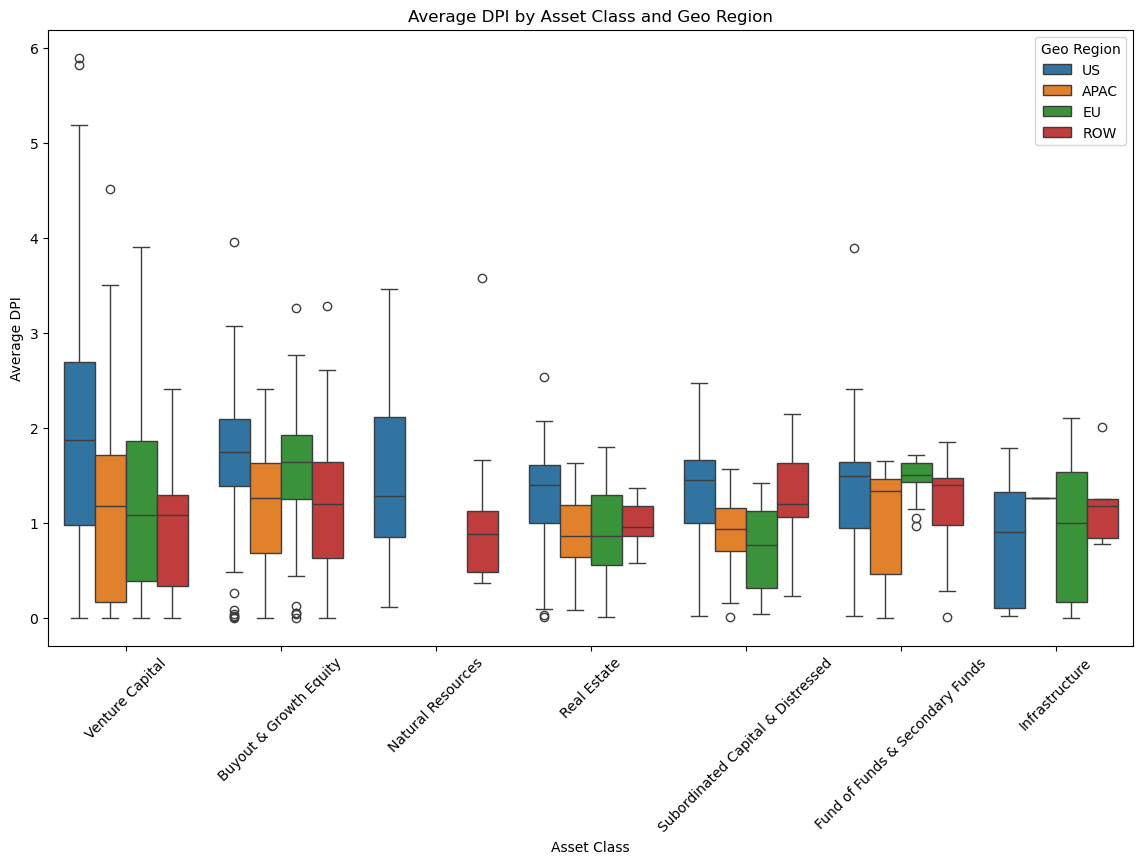

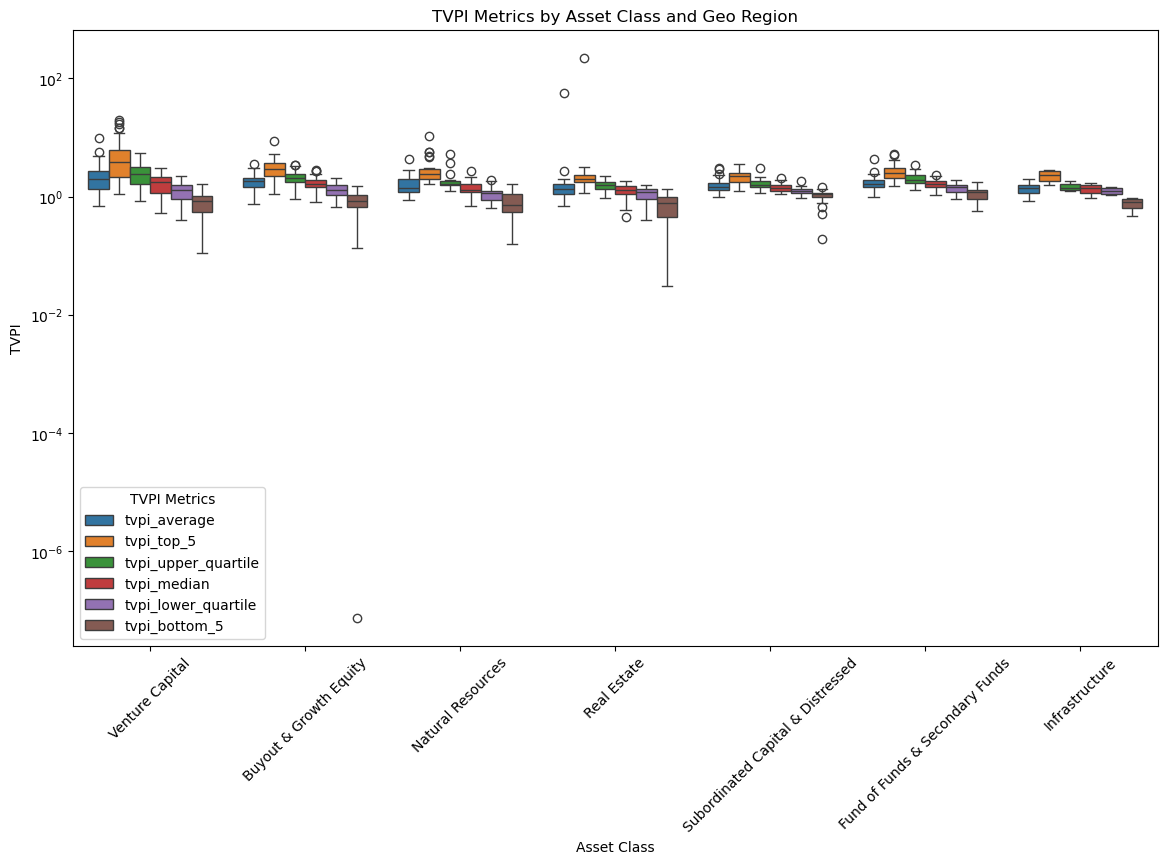

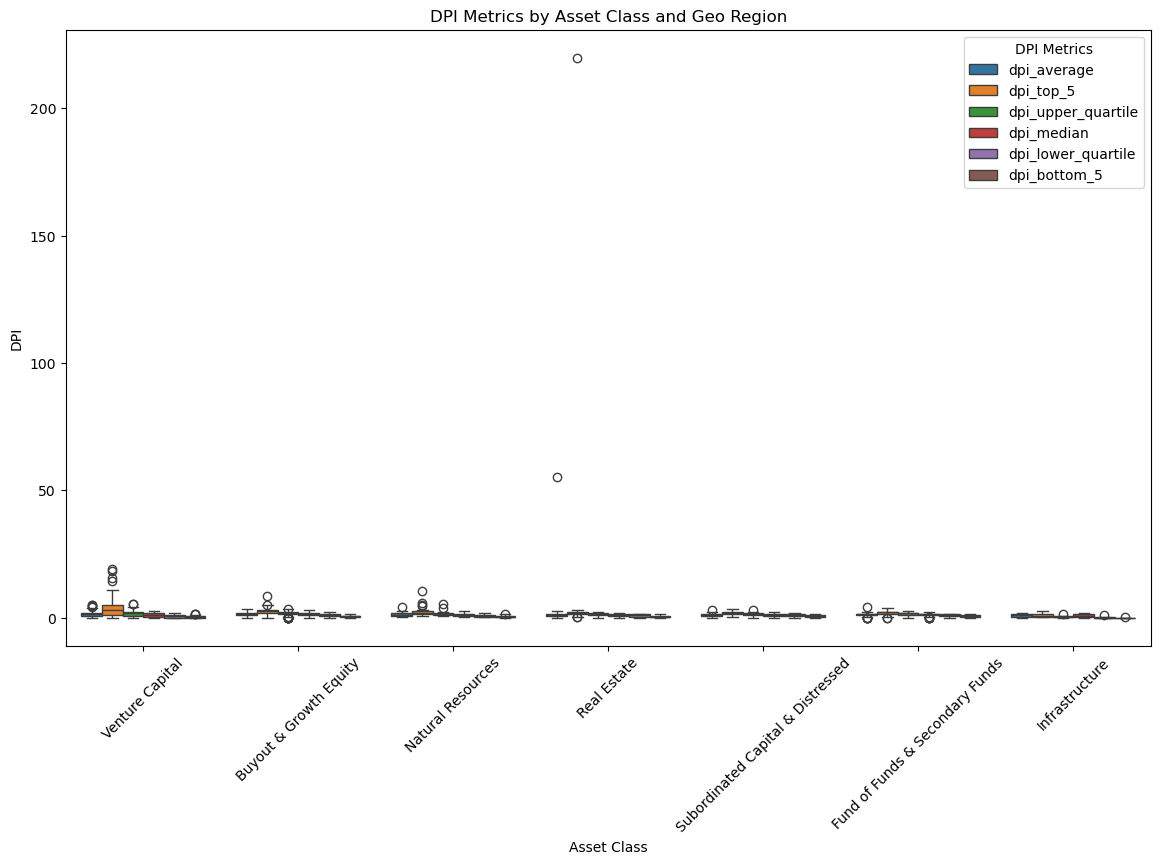

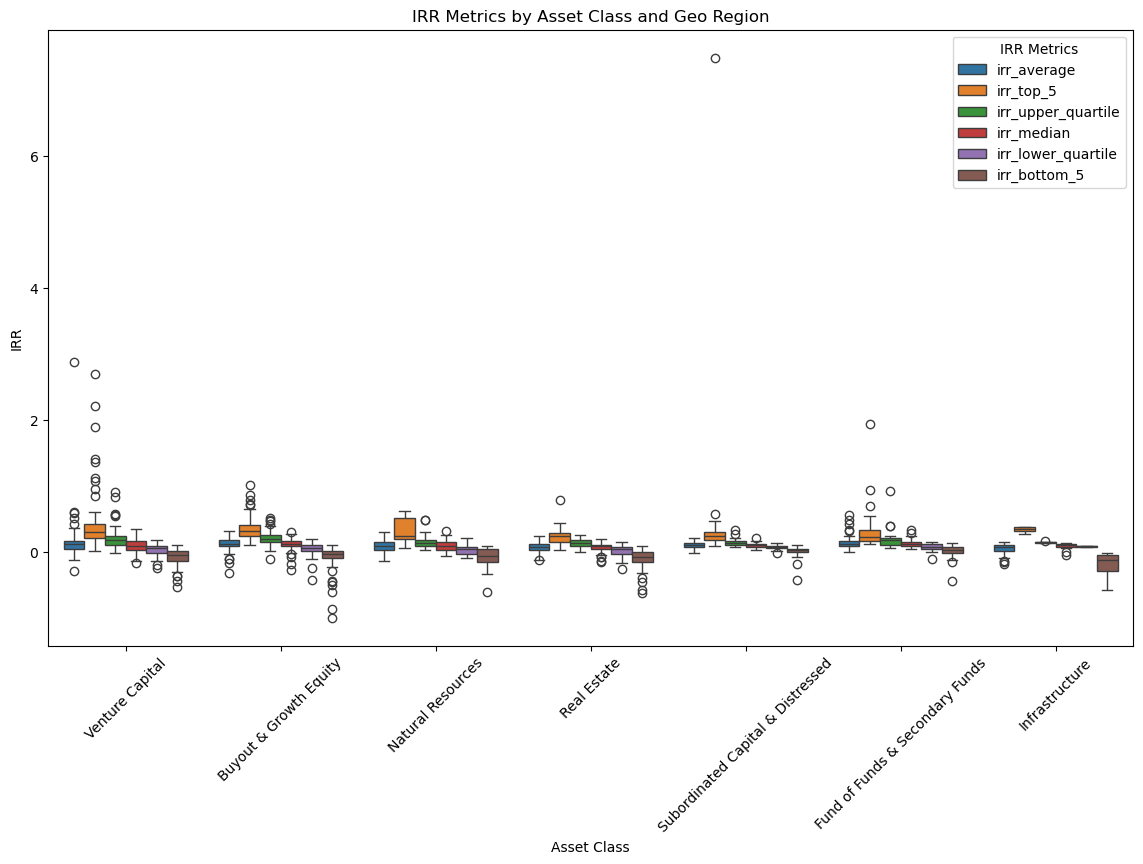

In [8]:
# Group by 'vintage_year' and 'geo_region' to calculate the total fund count for each region and year
fund_count_by_year_region = data.groupby(['vintage_year', 'geo_region'])['fund_count'].sum().reset_index()

# Plot the time series with multiple lines for each 'geo_region'
plt.figure(figsize=(25, 8))
sns.lineplot(data=fund_count_by_year_region, x='vintage_year', y='fund_count', hue='geo_region', marker="o")
plt.title('Total Fund Count Over Time by Geo Region')
plt.xlabel('Vintage Year')
plt.ylabel('Total Fund Count')
plt.legend(title='Geo Region')
plt.show()


# Group by 'vintage_year' and 'geo_region' to calculate the total fund count for each region and year
fund_count_by_asset = data.groupby(['vintage_year', 'asset_class'])['fund_count'].sum().reset_index()

# Plot the time series with multiple lines for each 'geo_region'
plt.figure(figsize=(25, 8))
sns.lineplot(data=fund_count_by_asset, x='vintage_year', y='fund_count', hue='asset_class', marker="o")
plt.title('Total Fund Count Over Time by Geo Region')
plt.xlabel('Vintage Year')
plt.ylabel('Total Fund Count')
plt.legend(title='Geo Region')
plt.show()


# Calculate summary statistics for each vintage year and asset class
irr_stats = data.groupby(['vintage_year', 'asset_class']).agg(
    irr_avg=('irr_average', 'mean'),
    irr_10th=('irr_average', lambda x: x.quantile(0.1)),
    irr_90th=('irr_average', lambda x: x.quantile(0.9))
).reset_index()

# Plot the lineplot with a dispersion cone
plt.figure(figsize=(25, 8))

# Iterate over each asset class to plot separate lines and cones
for asset_class in irr_stats['asset_class'].unique():
    subset = irr_stats[irr_stats['asset_class'] == asset_class]
    
    # Plot mean IRR line
    sns.lineplot(data=subset, x='vintage_year', y='irr_avg', label=f'{asset_class} - Avg IRR')
    
    # Plot the dispersion cone (fill between 10th and 90th percentiles)
    plt.fill_between(
        subset['vintage_year'],
        subset['irr_10th'],
        subset['irr_90th'],
        alpha=0.2
    )
# Add plot labels and legend
plt.title('IRR Average with Dispersion Cone by Asset Class')
plt.xlabel('Vintage Year')
plt.ylabel('IRR Average')
plt.legend(title='Asset Class')
plt.show()



# Calculate summary statistics for each vintage year and geo_region
irr_stats_region = data.groupby(['vintage_year', 'geo_region']).agg(
    irr_avg=('irr_average', 'mean'),
    irr_10th=('irr_average', lambda x: x.quantile(0.1)),
    irr_90th=('irr_average', lambda x: x.quantile(0.9))
).reset_index()

# Plot the lineplot with a dispersion cone
plt.figure(figsize=(25, 8))  # Ensure we only create one figure

# Iterate over each geo_region to plot separate lines and cones
for region in irr_stats_region['geo_region'].unique():
    subset = irr_stats_region[irr_stats_region['geo_region'] == region]
    
    # Plot mean IRR line
    sns.lineplot(data=subset, x='vintage_year', y='irr_avg', label=f'{region} - Avg IRR')
    
    # Plot the dispersion cone (fill between 10th and 90th percentiles)
    plt.fill_between(
        subset['vintage_year'],
        subset['irr_10th'],
        subset['irr_90th'],
        alpha=0.2
    )

# Add plot labels and legend
plt.title('IRR Average with Dispersion Cone by Geo Region')
plt.xlabel('Vintage Year')
plt.ylabel('IRR Average')
plt.legend(title='Geo Region')
plt.show()


# 1. Histogram and KDE plot of Fund Count
plt.figure(figsize=(14, 8))
sns.barplot(data=data, y='fund_count', hue='asset_class', palette='bright')
plt.title('Distribution of Fund Count')
plt.xlabel('Fund Count')
plt.ylabel('Frequency')
plt.show()



# 3. Boxplot of Fund Count by Asset Class
plt.figure(figsize=(14, 8))
sns.boxplot(data=data, x='asset_class', y='fund_count', hue='geo_region')
plt.title('Fund Count by Asset Class and Geo Region')
plt.xlabel('Asset Class')
plt.ylabel('Fund Count')
plt.legend(title='Geo Region')
plt.xticks(rotation=45)
plt.show()

# Average IRR by geo_region
plt.figure(figsize=(14, 8))
sns.boxplot(data=data, x='geo_region', y='irr_average')
plt.title('Average IRR by Geo Region')
plt.xlabel('Geo Region')
plt.ylabel('Average IRR')
plt.show()


# Plotting dispersion of geo_region for each asset_class in terms of avg TVPI, DPI, and IRR


# 3. Average IRR by Asset Class and Geo Region
plt.figure(figsize=(14, 8))
sns.boxplot(data=data, x='asset_class', y='irr_pooled', hue='geo_region')
plt.title('Average IRR by Asset Class and Geo Region')
plt.xlabel('Asset Class')
plt.ylabel('Average IRR')
plt.legend(title='Geo Region')
plt.xticks(rotation=45)
plt.show()

# 1. Average TVPI by Asset Class and Geo Region
plt.figure(figsize=(14, 8))
sns.boxplot(data=data, x='asset_class', y='tvpi_pooled', hue='geo_region')
plt.title('Average TVPI by Asset Class and Geo Region')
plt.xlabel('Asset Class')
plt.ylabel('Average TVPI')
plt.legend(title='Geo Region')
plt.xticks(rotation=45)
plt.show()

# 2. Average DPI by Asset Class and Geo Region
plt.figure(figsize=(14, 8))
sns.boxplot(data=data, x='asset_class', y='dpi_pooled', hue='geo_region')
plt.title('Average DPI by Asset Class and Geo Region')
plt.xlabel('Asset Class')
plt.ylabel('Average DPI')
plt.legend(title='Geo Region')
plt.xticks(rotation=45)
plt.show()


# Boxplot of TVPI by Asset Class and Geo Region (with multiple metrics)
plt.figure(figsize=(14, 8))
sns.boxplot(data=pd.melt(data, id_vars=['asset_class', 'geo_region'], 
                         value_vars=['tvpi_average', 'tvpi_top_5', 'tvpi_upper_quartile', 'tvpi_median', 
                                     'tvpi_lower_quartile', 'tvpi_bottom_5']),
            x='asset_class', y='value', hue='variable')
plt.title('TVPI Metrics by Asset Class and Geo Region')
plt.xlabel('Asset Class')
plt.ylabel('TVPI')
plt.legend(title='TVPI Metrics')
plt.yscale('log')
plt.xticks(rotation=45)
plt.show()

# Boxplot of DPI by Asset Class and Geo Region (with multiple metrics)
plt.figure(figsize=(14, 8))
sns.boxplot(data=pd.melt(data, id_vars=['asset_class', 'geo_region'], 
                         value_vars=['dpi_average', 'dpi_top_5', 'dpi_upper_quartile', 'dpi_median', 
                                     'dpi_lower_quartile', 'dpi_bottom_5']),
            x='asset_class', y='value', hue='variable')
plt.title('DPI Metrics by Asset Class and Geo Region')
plt.xlabel('Asset Class')
plt.ylabel('DPI')
plt.legend(title='DPI Metrics')
# plt.yscale('log')
plt.xticks(rotation=45)
plt.show()

# Boxplot of IRR by Asset Class and Geo Region (with multiple metrics)
plt.figure(figsize=(14, 8))
sns.boxplot(data=pd.melt(data, id_vars=['asset_class', 'geo_region'], 
                         value_vars=['irr_average', 'irr_top_5', 'irr_upper_quartile', 'irr_median', 
                                     'irr_lower_quartile', 'irr_bottom_5']),
            x='asset_class', y='value', hue='variable')
plt.title('IRR Metrics by Asset Class and Geo Region')
plt.xlabel('Asset Class')
plt.ylabel('IRR')
plt.legend(title='IRR Metrics')
# plt.yscale('log')
plt.xticks(rotation=45)
plt.show()




